# Physics-informed Machine Learning (scenarios)

**Objective**: We will generate synthetic, noisy "observational data" of a celestial source. Then, we will pit two approaches against each other:

1. The "Old School" Analytic Model: The Rayleigh-Jeans approximation (what we derived in theory).

2. The "AI" Model: A simple Neural Network (using scikit-learn) that tries to learn the relationship between Frequency and Brightness purely from the data, without knowing any physics equations.

**What to look for:** Can the AI figure out the "curve" (Planck's Law) where the Rayleigh-Jeans approximation fails, just by looking at the data points?

We will explore `sklearn.neural_networkMLPRegressor` for this example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# 1. Generate Synthetic "Observational" Data

# Physics Constants
h = 6.626e-34
k = 1.381e-23
c = 3.0e8
T_source = 50.0 # Kelvin

In [3]:
def planck_law(nu, T):
    term1 = (2 * h * nu**3) / c**2
    term2 = 1 / (np.exp((h * nu) / (k * T)) - 1)
    return term1 * term2

def rayleigh_jeans(nu, T):
    return (2 * nu**2 * k * T) / c**2


# Create a frequency range spanning Radio to Far-IR
# We generate 200 random data points to simulate "observations"
# Range: 10 MHz to 3 THz
X_observations = np.random.uniform(1e7, 3e12, 200).reshape(-1, 1)

# Calculate "True" Physics values
y_true = planck_law(X_observations.flatten(), T_source)

# Add "Telescope Noise" (Gaussian noise)
noise_level = 0.05 * np.max(y_true) # 5% noise
y_noisy = y_true + np.random.normal(0, noise_level, len(y_true))

In [4]:
# 2. Adding the AI Approach (Neural Network)

# Data Science Best Practice: Always scale your data for Neural Nets!
# Frequencies are huge (10^12) and Brightness is tiny (10^-15), which confuses the AI.
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_observations)
y_scaled = scaler_y.fit_transform(y_noisy.reshape(-1, 1)).flatten()

# Initialize a Multi-Layer Perceptron (MLP)
# Hidden layers: (64, 64) means a network with 2 layers of 64 neurons each
model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', 
                     solver='adam', max_iter=2000, random_state=42)

# Train the model ("Fit" the data)
print("Training Neural Network...")
model.fit(X_scaled, y_scaled)
print("Training Complete.")

Training Neural Network...
Training Complete.


In [5]:
# 3. Predictions for Visualization
# Create a smooth line for plotting

X_plot = np.linspace(1e7, 3e12, 500).reshape(-1, 1)
X_plot_scaled = scaler_X.transform(X_plot)

# AI Prediction
y_pred_scaled = model.predict(X_plot_scaled)
y_pred_ai = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Physics Approximation (Rayleigh-Jeans) Prediction
y_rj = rayleigh_jeans(X_plot.flatten(), T_source)
y_true_curve = planck_law(X_plot.flatten(), T_source)

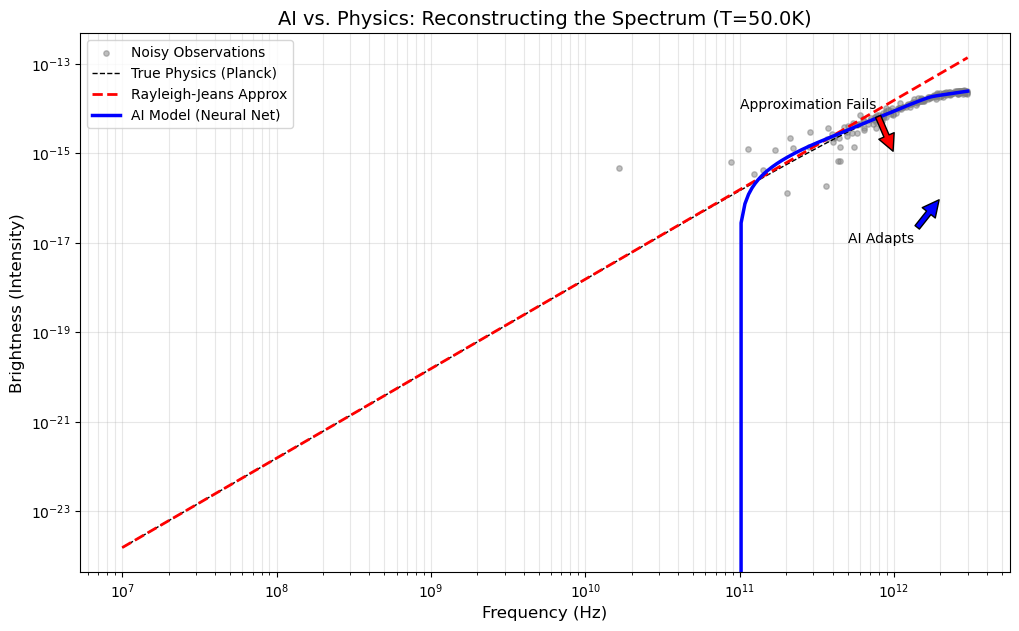

In [6]:
# 4. Visualizations

plt.figure(figsize=(12, 7))

# Plot the noisy "training data"
plt.scatter(X_observations, y_noisy, color='gray', alpha=0.5, label='Noisy Observations', s=15)

# Plot the True Physics (Ground Truth)
plt.plot(X_plot, y_true_curve, 'k--', label='True Physics (Planck)', linewidth=1)

# Plot the Rayleigh-Jeans Approximation
plt.plot(X_plot, y_rj, color='red', linestyle='--', label='Rayleigh-Jeans Approx', linewidth=2)

# Plot the AI Model
plt.plot(X_plot, y_pred_ai, color='blue', label='AI Model (Neural Net)', linewidth=2.5)

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Brightness (Intensity)', fontsize=12)
plt.title(f'AI vs. Physics: Reconstructing the Spectrum (T={T_source}K)', fontsize=14)
plt.legend()
plt.grid(True, which="both", alpha=0.3)

# Add a text annotation pointing out the breakdown
plt.annotate('Approximation Fails', xy=(1e12, 1e-15), xytext=(1e11, 1e-14),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate('AI Adapts', xy=(2e12, 1e-16), xytext=(5e11, 1e-17),
             arrowprops=dict(facecolor='blue', shrink=0.05))

plt.show()